In [5]:
import h5py

hdf_path = "/kaggle/input/isp-ad-dataset/supervised_ASM/supervised_ASM/train/syn_train_asm.hdf5"

with h5py.File(hdf_path, "r") as f:
    print("Keys in file:", list(f.keys()))
    for k in f.keys():
        print(f"{k} -> shape: {f[k].shape}, dtype: {f[k].dtype}")



Keys in file: ['ground_truth', 'syn_stream']
ground_truth -> shape: (199991, 1, 256, 256), dtype: bool
syn_stream -> shape: (199991, 1, 256, 256), dtype: uint8


⚡ Using subset of train: 20000 samples
Train: 20000, Val: 19999, Test: 1916
Using device: cuda
Epoch 1/2 Train Loss: 0.0315 Val Loss: 0.0191 IoU: 0.5000 Dice: 0.0030
💾 Saved checkpoint: /kaggle/working/checkpoints/epoch_1.pth
✅ Updated best model


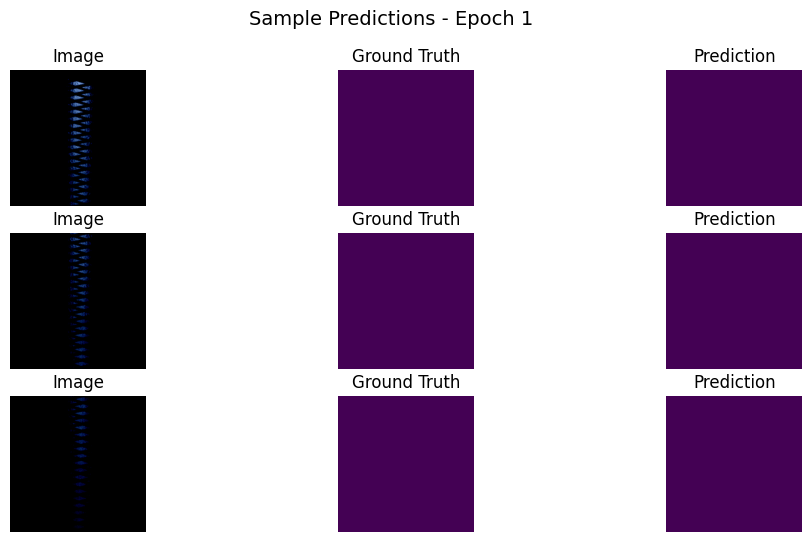

In [ ]:
# ================================
# DeepLabV3 Training on ISP-AD ASM
# ================================

import os, re, h5py, numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision.transforms.functional as TF
import torchvision.models.segmentation as models
from PIL import Image
import matplotlib.pyplot as plt

# ------------------
# Dataset from HDF5
# ------------------
class ISPADHDF5Dataset(Dataset):
    def __init__(self, hdf5_path, image_size=(256,256)):
        self.hdf5_path = hdf5_path
        self.image_size = image_size
        self.file = None  # will open lazily
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
        with h5py.File(self.hdf5_path, "r") as f:
            self.n_samples = f["syn_stream"].shape[0]

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        if self.file is None:
            self.file = h5py.File(self.hdf5_path, "r")
            self.imgs = self.file["syn_stream"]
            self.masks = self.file["ground_truth"]

        img = self.imgs[idx][0]      # (256,256)
        mask = self.masks[idx][0]    # (256,256), bool

        img = Image.fromarray(img).convert("RGB")
        mask = Image.fromarray(mask.astype(np.uint8)*255)

        img = img.resize(self.image_size)
        mask = mask.resize(self.image_size)

        img = TF.to_tensor(img)
        img = self.normalize(img)
        mask = torch.from_numpy(np.array(mask)).long() // 255

        return img, mask

# ------------------
# Dataset from PNG
# ------------------
class ISPADDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_size=(256,256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_size = image_size
        self.files = sorted(set(os.listdir(image_dir)) & set(os.listdir(mask_dir)))
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        img_path = os.path.join(self.image_dir, fname)
        mask_path = os.path.join(self.mask_dir, fname)

        image = Image.open(img_path).convert("RGB")
        mask  = Image.open(mask_path).convert("L")

        image = image.resize(self.image_size)
        mask  = mask.resize(self.image_size)

        image = TF.to_tensor(image)
        image = self.normalize(image)
        mask = torch.from_numpy(np.array(mask)).long() // 255

        return image, mask

# ------------------
# Metrics
# ------------------
def compute_iou(pred, target, num_classes=2):
    pred = pred.view(-1)
    target = target.view(-1)
    ious = []
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds[target_inds]).sum().item()
        union = pred_inds.sum().item() + target_inds.sum().item() - intersection
        if union == 0:
            ious.append(float("nan"))
        else:
            ious.append(intersection / union)
    return np.nanmean(ious)

def compute_dice(pred, target, smooth=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum().item()
    return (2. * intersection + smooth) / (pred.sum().item() + target.sum().item() + smooth)

# ------------------
# Prepare Datasets
# ------------------
HDF_PATH = "/kaggle/input/isp-ad-dataset/supervised_ASM/supervised_ASM/train/syn_train_asm.hdf5"
TRAIN_IMG_DIR = "/kaggle/working/asm/train_images"   # not used now
TRAIN_MASK_DIR = "/kaggle/working/asm/train_masks"   # not used now
TEST_IMG_DIR = "/kaggle/working/asm/test_images"
TEST_MASK_DIR = "/kaggle/working/asm/test_masks"

# train/val from HDF5
full_dataset = ISPADHDF5Dataset(HDF_PATH, image_size=(256,256))
n = len(full_dataset)
n_val = int(0.1 * n)
n_train = n - n_val
train_dataset, val_dataset = random_split(full_dataset, [n_train, n_val])

from torch.utils.data import Subset

# Optional: reduce train set for quicker runs
TRAIN_SUBSET_SIZE = 20000   # set None for full dataset

if TRAIN_SUBSET_SIZE is not None and TRAIN_SUBSET_SIZE < len(train_dataset):
    idx = torch.randperm(len(train_dataset))[:TRAIN_SUBSET_SIZE].tolist()
    train_dataset = Subset(train_dataset, idx)
    print(f"⚡ Using subset of train: {len(train_dataset)} samples")


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

# test from PNG
test_dataset = ISPADDataset(TEST_IMG_DIR, TEST_MASK_DIR, image_size=(256,256))
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

# ------------------
# Model
# ------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = models.deeplabv3_resnet101(weights=None, num_classes=2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ------------------
# Training
# ------------------
from pathlib import Path
import matplotlib.pyplot as plt

num_epochs = 2
save_dir = Path("/kaggle/working/checkpoints")
save_dir.mkdir(parents=True, exist_ok=True)

best_val_iou = 0.0

for epoch in range(num_epochs):
    # --- Train ---
    model.train()
    train_loss = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # --- Validate ---
    model.eval()
    val_loss = 0
    val_ious, val_dices = [], []
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)['out']
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            preds = outputs.argmax(1)
            val_ious.append(compute_iou(preds.cpu(), masks.cpu()))
            val_dices.append(compute_dice((preds>0).cpu(), (masks>0).cpu()))

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = np.nanmean(val_ious)
    avg_val_dice = np.nanmean(val_dices)

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"Train Loss: {avg_train_loss:.4f} "
          f"Val Loss: {avg_val_loss:.4f} "
          f"IoU: {avg_val_iou:.4f} "
          f"Dice: {avg_val_dice:.4f}")

    # --- Save checkpoint ---
    ckpt_path = save_dir / f"epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), ckpt_path)
    print(f"💾 Saved checkpoint: {ckpt_path}")

    # --- Save best model ---
    if avg_val_iou > best_val_iou:
        best_val_iou = avg_val_iou
        torch.save(model.state_dict(), "best_deeplabv3.pth")
        print("✅ Updated best model")

    # --- Visualization on test samples ---
    model.eval()
    imgs, masks = next(iter(test_loader))
    with torch.no_grad():
        outputs = model(imgs.to(device))['out']
        preds = outputs.argmax(1).cpu()

    plt.figure(figsize=(12, 6))
    for i in range(3):
        plt.subplot(3, 3, i*3+1)
        plt.imshow(imgs[i].permute(1,2,0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(3, 3, i*3+2)
        plt.imshow(masks[i])
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(3, 3, i*3+3)
        plt.imshow(preds[i])
        plt.title("Prediction")
        plt.axis("off")
    plt.suptitle(f"Sample Predictions - Epoch {epoch+1}", fontsize=14)
    plt.show()



In [2]:
import os, re
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm

# --- input paths ---
ASM_TEST_ROOT = "/kaggle/input/isp-ad-dataset/supervised_ASM/supervised_ASM/test"
DEFECT_DIR = os.path.join(ASM_TEST_ROOT, "defects")
GOOD_DIR   = os.path.join(ASM_TEST_ROOT, "good")

# --- output paths ---
OUT_TEST_IMG  = Path("/kaggle/working/asm/test_images")
OUT_TEST_MASK = Path("/kaggle/working/asm/test_masks")
OUT_TEST_IMG.mkdir(parents=True, exist_ok=True)
OUT_TEST_MASK.mkdir(parents=True, exist_ok=True)

# --- helper: extract numeric ID from filename ---
def get_id(fname):
    m = re.match(r"^(\d+)", fname)
    return int(m.group(1)) if m else None

# --- process defect cases ---
defect_masks = [f for f in os.listdir(DEFECT_DIR) if f.endswith(".png") and "_area_" in f]
for f in tqdm(defect_masks, desc="Processing defect cases"):
    base_id = get_id(f)
    if base_id is None:
        continue

    # save mask (binary)
    mask_path = os.path.join(DEFECT_DIR, f)
    mask = Image.open(mask_path).convert("L")
    mnp = (np.array(mask) > 0).astype(np.uint8) * 255
    Image.fromarray(mnp).save(OUT_TEST_MASK / f"{base_id:06d}.png")

    # matching image should exist as "{id}.png" or "{id}_defect_asm.png"
    candidates = [
        os.path.join(DEFECT_DIR, f"{base_id}.png"),
        os.path.join(DEFECT_DIR, f"{base_id}_defect_asm.png"),
    ]
    img_path = None
    for c in candidates:
        if os.path.exists(c):
            img_path = c
            break
    if img_path is None:
        print(f"⚠️ No matching defect image for {f}")
        continue

    img = Image.open(img_path).convert("RGB")
    img.save(OUT_TEST_IMG / f"{base_id:06d}.png")

# --- process good cases ---
good_imgs = [f for f in os.listdir(GOOD_DIR) if f.endswith(".png")]
for f in tqdm(good_imgs, desc="Processing good cases"):
    base_id = get_id(f)
    if base_id is None:
        continue

    # save image
    img = Image.open(os.path.join(GOOD_DIR, f)).convert("RGB")
    img.save(OUT_TEST_IMG / f"{base_id:06d}.png")

    # zero mask
    mask = np.zeros((img.size[1], img.size[0]), dtype=np.uint8)
    Image.fromarray(mask).save(OUT_TEST_MASK / f"{base_id:06d}.png")

print("✅ Test set prepared")
print("Images:", len(os.listdir(OUT_TEST_IMG)))
print("Masks :", len(os.listdir(OUT_TEST_MASK)))


Processing defect cases:  48%|████▊     | 16/33 [00:00<00:00, 79.67it/s]

⚠️ No matching defect image for 3_area_asm.png
⚠️ No matching defect image for 18_area_asm.png
⚠️ No matching defect image for 26_area_asm.png
⚠️ No matching defect image for 31_area_asm.png
⚠️ No matching defect image for 5_area_asm.png
⚠️ No matching defect image for 1_area_asm.png
⚠️ No matching defect image for 32_area_asm.png
⚠️ No matching defect image for 15_area_asm.png
⚠️ No matching defect image for 28_area_asm.png
⚠️ No matching defect image for 11_area_asm.png
⚠️ No matching defect image for 10_area_asm.png
⚠️ No matching defect image for 9_area_asm.png
⚠️ No matching defect image for 24_area_asm.png
⚠️ No matching defect image for 25_area_asm.png
⚠️ No matching defect image for 12_area_asm.png
⚠️ No matching defect image for 20_area_asm.png
⚠️ No matching defect image for 29_area_asm.png
⚠️ No matching defect image for 16_area_asm.png
⚠️ No matching defect image for 6_area_asm.png
⚠️ No matching defect image for 33_area_asm.png
⚠️ No matching defect image for 27_area_asm.p

Processing defect cases: 100%|██████████| 33/33 [00:00<00:00, 86.81it/s]


⚠️ No matching defect image for 23_area_asm.png
⚠️ No matching defect image for 13_area_asm.png
⚠️ No matching defect image for 22_area_asm.png
⚠️ No matching defect image for 19_area_asm.png
⚠️ No matching defect image for 7_area_asm.png
⚠️ No matching defect image for 17_area_asm.png
⚠️ No matching defect image for 21_area_asm.png
⚠️ No matching defect image for 8_area_asm.png
⚠️ No matching defect image for 4_area_asm.png
⚠️ No matching defect image for 30_area_asm.png
⚠️ No matching defect image for 2_area_asm.png
⚠️ No matching defect image for 14_area_asm.png


Processing good cases: 100%|██████████| 1916/1916 [00:46<00:00, 41.10it/s]

✅ Test set prepared
Images: 1916
Masks : 1916


In [3]:
import h5py, numpy as np, os, re
from pathlib import Path
from PIL import Image
from tqdm import tqdm

# --- config ---
ASM_ROOT = "/kaggle/input/isp-ad-dataset/supervised_ASM/supervised_ASM"
HDF_PATH = f"{ASM_ROOT}/train/syn_train_asm.hdf5"
MASK_DIR = f"{ASM_ROOT}/train/defects"   # contains *_area_asm.png

OUT_IMG_DIR  = Path("/kaggle/working/asm/train_images")
OUT_MASK_DIR = Path("/kaggle/working/asm/train_masks")
OUT_IMG_DIR.mkdir(parents=True, exist_ok=True)
OUT_MASK_DIR.mkdir(parents=True, exist_ok=True)

# --- collect available area masks (only *_area_asm.png) ---
area_files = [f for f in os.listdir(MASK_DIR) if f.endswith(".png") and "_area_" in f]
id_pat = re.compile(r"^(\d+)_")
ids = []
for f in area_files:
    m = id_pat.match(f)
    if m: ids.append(int(m.group(1)))
ids = sorted(set(ids))

print(f"Found {len(ids)} area masks")

# --- export matching images from HDF5 ---
with h5py.File(HDF_PATH, "r") as f:
    imgs = f["syn_stream"]       # grayscale images
    N = len(imgs)
    missing = []
    for i in tqdm(ids, desc="Exporting images"):
        if i >= N:
            missing.append(i)
            continue
        arr = imgs[i][0]                         # shape (256,256)
        Image.fromarray(arr).convert("L").save(OUT_IMG_DIR / f"{i:06d}.png")

print(f"Exported {len(ids)-len(missing)} images to {OUT_IMG_DIR}")
if missing:
    print(f"⚠️ Missing {len(missing)} image IDs, e.g. {missing[:5]}")

# --- copy & normalize masks ---
copied = 0
for f in area_files:
    m = id_pat.match(f)
    if not m: continue
    i = int(m.group(1))
    src = Path(MASK_DIR) / f
    dst = OUT_MASK_DIR / f"{i:06d}.png"

    mask = Image.open(src).convert("L")
    mnp = np.array(mask)
    mnp = (mnp > 0).astype(np.uint8) * 255  # binarize
    Image.fromarray(mnp).save(dst)
    copied += 1

print(f"Copied {copied} masks to {OUT_MASK_DIR}")

# --- sanity check ---
img_names = set(os.listdir(OUT_IMG_DIR))
msk_names = set(os.listdir(OUT_MASK_DIR))
pairs = sorted(img_names & msk_names)
print(f"✅ Paired samples: {len(pairs)}")
print("Sample pair:", pairs[:5])


Found 37 area masks


Exporting images: 100%|██████████| 37/37 [00:00<00:00, 122.59it/s]


Exported 37 images to /kaggle/working/asm/train_images
Copied 37 masks to /kaggle/working/asm/train_masks
✅ Paired samples: 37
Sample pair: ['000001.png', '000002.png', '000003.png', '000004.png', '000005.png']



* loads the ASM synthetic training set directly from HDF5 (syn_train_asm.hdf5)
* Splits it into train/valUses
* the PNG-based test set we prepared earlier (test_images/, test_masks/)
* Trains a DeepLabV3 (ResNet101)
* modelEvaluates with IoU and Dice metrics
* Saves the best model
